# SECTION FOR EVALUATION
In this section, all three models will be loaded along with their corresponding CSV files. However, none of these files will be provided. Therefore, if you run the model segmentation code, you can generate your own models along with their corresponding CSV files and history. which then you can use in this code.

This code is expecting a model file.h5 and a csv file and a history file.pkl for each model (U-NET, FCNN, DeepLabV3).

In [11]:
# Azure access api
!pip install azure-storage-blob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from azure.storage.blob import BlobServiceClient
from keras.models import load_model
import random
import cv2
import pickle
from sklearn.metrics import *
import pandas as pd
import tensorflow as tf
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange

In [13]:
# establishing the connection
connect_str = 'DefaultEndpointsProtocol=https;AccountName=yaghmo;AccountKey=rYEvETXhJXd7+434KglSzII1CdWGU67ZxSmH0Tcretb8tNksyTO3Dxs0icWQwlV2WJjp8AaS0kbd+ASthREo3w==;EndpointSuffix=core.windows.net'
# Create a BlobServiceClient object to interact with the storage account
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Access the container (the stored database)
container_name = 'path'
container_client = blob_service_client.get_container_client(container_name)

In [ ]:
#load the model + corresponding csv
#UNET
model_U_Net = load_model('model-U-Net.h5')
df = pd.read_csv('test_U-NET.csv')
image_U_NET, mask_U_NET = df.iloc[:,0], df.iloc[:,1]
with open('results_U-Net.pkl', 'rb') as f:
    U_Net_hist = pickle.load(f)

#DeepLabV3
model_DeepLabV3 = load_model('model-DeepLabV3.h5')
df = pd.read_csv('test_DeepLabV3.csv')
image_DeepLabV3, mask_DeepLabV3 = df.iloc[:,0], df.iloc[:,1]
with open('results_DeepLabV3.pkl', 'rb') as f:
    DeepLabV3_hist = pickle.load(f)


#FCNN
model_FCNN = load_model('model-FCNN.h5')
df = pd.read_csv('test_FCNN.csv')
image_FCNN, mask_FCNN = df.iloc[:,0], df.iloc[:,1]
with open('results_FCNN.pkl', 'rb') as f:
    FCNN_hist = pickle.load(f)

 

# Setting some parameters
im_width = 256
im_height = 256

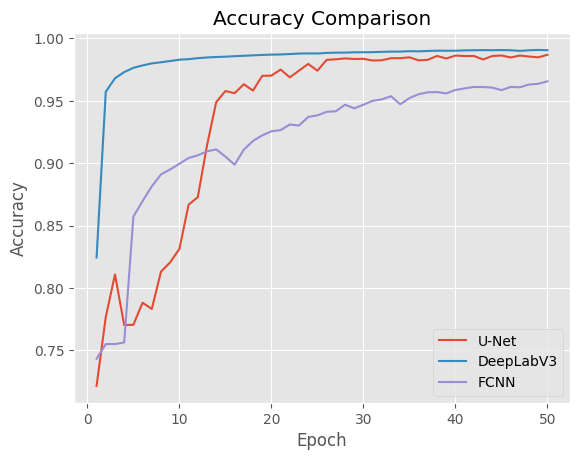

In [26]:
# Define the x-axis (e.g. number of epochs)
x = range(1, max(len(U_Net_hist['accuracy']),
                 len(DeepLabV3_hist['accuracy']),
                 len(FCNN_hist['accuracy'])) + 1)

# Plot the accuracy history for each model
plt.plot(x, U_Net_hist['val_accuracy'], label='U-Net')
plt.plot(x, DeepLabV3_hist['accuracy'], label='DeepLabV3')
plt.plot(x, FCNN_hist['accuracy'], label='FCNN')

# Add a legend, title, and axis labels
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

In [18]:
def get_image_mask(id_images,id_masks):
  images = np.zeros(((len(id_images)), im_height, im_width), dtype=np.float32)
  masks = np.zeros(((len(id_masks)), im_height, im_width), dtype=np.float32)


  for i, file_name in tqdm_notebook(enumerate(id_images), total=len(id_images)):
      # Load images
      blob_client = container_client.get_blob_client(file_name)
      data = blob_client.download_blob().content_as_bytes()
      arr = np.frombuffer(data, np.uint8)
      img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)

      #pre process
      #Gaussian blur
      img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
      #morpho gradient
      image = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
      image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
      #egalization
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      img_clahe = clahe.apply(image)
      img = resize(img_clahe, (im_width, im_height), mode='constant', preserve_range=True)
      images[i] = img/255


  for i, file_name in tqdm_notebook(enumerate(id_masks), total=len(id_masks)):
      # Load images
      blob_client = container_client.get_blob_client(file_name)
      data = blob_client.download_blob().content_as_bytes()
      arr = np.frombuffer(data, np.uint8)
      img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
      img = resize(img, (im_width, im_height), mode='constant', preserve_range=True)
      masks[i] = img/255

  return images,masks


In [19]:
X_test_U_NET, y_test_U_NET = get_image_mask(image_U_NET,mask_U_NET)
print('*'*30,'U-Net test dat loaded','*'*30)
X_test_DeepLabV3, y_test_DeepLabV3 = get_image_mask(image_DeepLabV3,mask_DeepLabV3)
print('*'*30,'DeepLabV3 test data loaded','*'*30)
X_test_FCNN, y_test_FCNN = get_image_mask(image_FCNN,mask_FCNN)
print('*'*30,'FCNN test data loaded','*'*30)


<ipython-input-18-5a2ed472532f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file_name in tqdm_notebook(enumerate(id_images), total=len(id_images)):


  0%|          | 0/362 [00:00<?, ?it/s]

<ipython-input-18-5a2ed472532f>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file_name in tqdm_notebook(enumerate(id_masks), total=len(id_masks)):


  0%|          | 0/362 [00:00<?, ?it/s]

****************************** U-Net test dat loaded ******************************


  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

****************************** DeepLabV3 test data loaded ******************************


  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

****************************** FCNN test data loaded ******************************


In [20]:
#predictions
#U NET
U_NET_preds = model_U_Net.predict(X_test_U_NET, verbose=1)
U_NET_preds_test = U_NET_preds.copy()
U_NET_preds_test2 = U_NET_preds.copy()
U_NET_preds_test3 = U_NET_preds.copy()

# #DeepLabV3
DeepLabV3_preds = model_DeepLabV3.predict(X_test_DeepLabV3, verbose=1)
DeepLabV3_preds_test = DeepLabV3_preds.copy()
DeepLabV3_preds_test2 = DeepLabV3_preds.copy()
DeepLabV3_preds_test3 = DeepLabV3_preds.copy()

# #FCNN
FCNN_preds = model_FCNN.predict(X_test_FCNN, verbose=1)
FCNN_preds_test = FCNN_preds.copy()
FCNN_preds_test2 = FCNN_preds.copy()
FCNN_preds_test3 = FCNN_preds.copy()


12/12 [==============================] - 39s 3s/step


In [21]:
#treshold the results

for x in [[U_NET_preds_test,U_NET_preds_test2,U_NET_preds_test3], [DeepLabV3_preds_test,DeepLabV3_preds_test2,DeepLabV3_preds_test3], [FCNN_preds_test,FCNN_preds_test2,FCNN_preds_test3]]:
  x[0][:][x[0][:] < np.mean(x[0][:])] = 0
  x[0][:][x[0][:] >= np.mean(x[0][:])] = 1

  for i in range(len(x[1])):
    x[1][i][x[1][i] < np.mean(x[1][i])] = 0
    x[1][i][x[1][i] >= np.mean(x[1][i])] = 1

  for i in range(len(x[2])):
    x[2][i] = x[2][i] + x[2][i] 
    x[2][i][x[2][i] >= 1] = 1


In [22]:
# metrics
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_score = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

In [23]:
evaluation = np.zeros((3,2))

def metrics(preds_test3,y_test):
  dice_scores = []
  mse = []
  preds_test = preds_test3.reshape(len(df), 256, 256)

  for i in range(len(y_test)):
      dice_scores.append(dice_coef(y_test[i], preds_test[i]))
      mse.append(mean_squared_error(y_test[i], preds_test[i]))

  mean_dice = np.mean(dice_scores)
  mse = np.mean(mse)
  
  return (mse,mean_dice)

In [24]:
evaluation[0] = metrics(U_NET_preds_test3,y_test_U_NET)
evaluation[1] = metrics(DeepLabV3_preds_test3,y_test_DeepLabV3)
evaluation[2] = metrics(FCNN_preds_test3,y_test_FCNN)

print('*'*43)
print('*','Metr|Meth',' *','U-NET','*','DeepLabV3','*',' FCNN',' *')
print('*'*43)
print(f'*  mean dice * {evaluation[0][1].round(2)}  *   {evaluation[1][1].round(2)}    *  {evaluation[2][1].round(2)}  *')
print('*'*43)
print("*    MSE     * {:.2f}  *  ".format(evaluation[0][0].round(2)),"{:.2f}    * ".format(evaluation[1][0].round(2)),"{:.2f}  *".format(evaluation[2][0].round(2)))
print('*'*43)

*******************************************
* Metr|Meth  * U-NET * DeepLabV3 *  FCNN  *
*******************************************
*  mean dice * 0.96  *   0.97    *  0.9  *
*******************************************
*    MSE     * 0.01  *   0.01    *  0.03  *
*******************************************


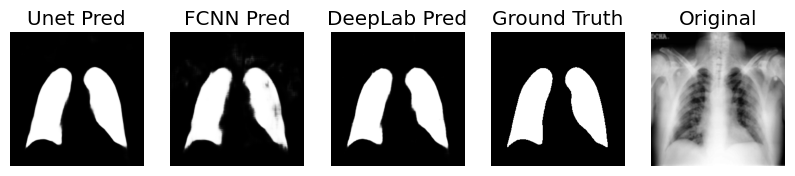

In [30]:
ix = random.randint(0, 100)

fig, axes = plt.subplots(1, 5,  figsize=(10,5))

axes[0].imshow(U_NET_preds[ix]*255,cmap='gray')
axes[1].imshow(FCNN_preds[ix]*255,cmap='gray')
axes[2].imshow(DeepLabV3_preds[ix]*255,cmap='gray')
axes[3].imshow(y_test_U_NET[ix]*255,cmap='gray')
axes[4].imshow(X_test_U_NET[ix]*255,cmap='gray')
axes[0].set_title('Unet Pred')
axes[1].set_title('FCNN Pred')
axes[2].set_title('DeepLab Pred')
axes[3].set_title('Ground Truth')
axes[4].set_title('Original')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
axes[4].axis('off')
# Show the figure
plt.show()